# Gaussian process regression in PyMC

Author: [Nipun Batra](https://nipunbatra.github.io/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from matplotlib import rc
import arviz as az
import warnings
warnings.filterwarnings('ignore')

rc('font', size=16)

We will use PyMC to do Gaussian process regression.

Let us define the RBF kernel as the following,

In [2]:
def kernel(a, b, lenghtscale, std):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return std**2*np.exp(-.5 * (1/lenghtscale) * sqdist)

We generate a synthetic dataset from a known distribution.

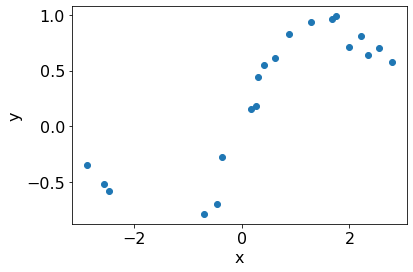

In [3]:
# From GPY tutorial
np.random.seed(0)
n_train = 20
X = np.random.uniform(-3.,3.,(n_train, 1))
Y = (np.sin(X) + np.random.randn(n_train, 1)*0.1).flatten()

plt.scatter(X[:, 0], Y);
plt.xlabel('x')
plt.ylabel('y');

we can define Gaussian process model in PyMC as the following,

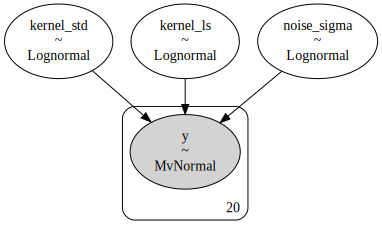

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    # Variance
    kernel_std = pm.Lognormal("kernel_std", 0, 0.1)
    # Length scale
    kernel_ls = pm.Lognormal("kernel_ls", 0, 1)
    noise_sigma = pm.Lognormal("noise_sigma", 0, 1)
    K = kernel(X, X, kernel_ls, kernel_std) 
    K += np.eye(X.shape[0]) * np.power(noise_sigma, 2)
    
    y = pm.MvNormal("y", mu = 0, cov = K, observed = Y)

pm.model_to_graphviz(basic_model.model)

Let us get MAP estimate of the paramaters.

In [5]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'kernel_std_log__': array(-0.03658128),
 'kernel_ls_log__': array(0.70103107),
 'noise_sigma_log__': array(-2.29810151),
 'kernel_std': array(0.96407973),
 'kernel_ls': array(2.01583009),
 'noise_sigma': array(0.10044936)}

Now, we draw a large number of samples from the posterior.

In [6]:
with basic_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sigma, kernel_ls, kernel_std]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.


We can visualize the dposterior distribution as the following,

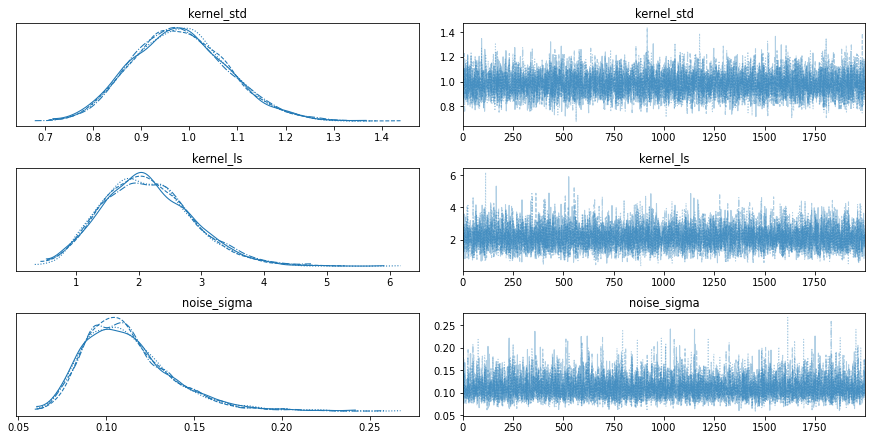

In [7]:
az.plot_trace(trace);

Let us predict at new input locations.

In [8]:
test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(train_x, train_y, test_x, kernel, kernel_ls, kernel_std, noise):
    N = len(train_x)
    K = kernel(train_x, train_x, kernel_ls, kernel_std)+noise**2*np.eye(len(train_x))
    N_star = len(test_x)
    K_star = kernel(train_x,  test_x, kernel_ls, kernel_std)
    K_star_star = kernel(test_x, test_x, kernel_ls, kernel_std)
    posterior_mu = K_star.T@np.linalg.inv(K)@(train_y)
    posterior_sigma = K_star_star - K_star.T@np.linalg.inv(K)@K_star
    
    
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu, posterior_sigma, size=1)

In [9]:
# Make predictions at new locations.
train_y = Y
n_samples = 500
preds = np.stack([post(train_x, train_y, test_x=test_x, kernel=kernel, kernel_ls=trace['kernel_ls'][b],
                             kernel_std=trace['kernel_std'][b],
                             noise=trace['noise_sigma'][b])
                  for b in range(n_samples)])

The figure below shows the mean and variance estimate of the posterior.

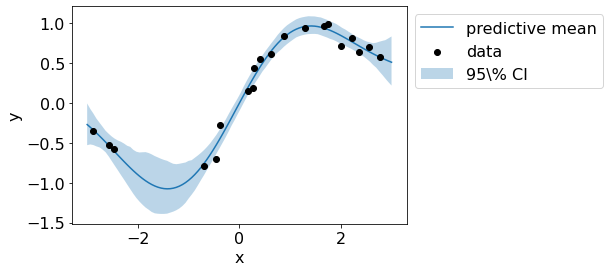

In [10]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0), label='predictive mean')


plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95\% CI');
plt.legend(bbox_to_anchor=(1,1));
plt.xlabel('x');plt.ylabel('y');